# MSA 2024 Phase 2 - Part 3

Welcome to the competition - in Part 3, you are encouraged to utilize neural network based models for classification.

This notebook builds a simple Multi-Layer Perceptron (MLP) model for the CIFAR-10 dataset, with the use of `keras` to define the model structure.

**Before start working on the competition, please ensure all required libraries are installed and properly set up on your system**:

- `python >= 3.6`,
- `tensorFlow >= 2.0`,
- `keras >= 2.3`,

and any neccassary liburaries for data manipulation and processing, e.g., `numpy`, `pandas`, etc.

In [1]:
import zipfile
import os
import time
from PIL import Image
import numpy as np
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report

### 1. Data loading & preprocessing

The CIFAR-10 dataset contains 60,000 images(32x32x3) in 10 different classes, with 6,000 images in each class. You can download the dataset directly from the competition webpage.

**To train the model, you are expected to use the training label provided in train.csv**.

In [2]:
# Function to unzip the dataset
def unzipDataset(data_dir):
    zip_path = data_dir + '.zip'
    extract_path = os.getcwd()

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)

# Paths to the zip files
train_zip_path = 'D:\\MSA_Project\\MSA_Phase2\\datasets\\cifar10\\train'
test_zip_path = 'D:\\MSA_Project\\MSA_Phase2\\datasets\\cifar10\\test'

# Unzip the datasets
unzipDataset(train_zip_path)
unzipDataset(test_zip_path)


In [3]:
# Paths to the datasets and CSV file
train_dir = 'D:\\MSA_Project\\MSA_Phase2\\datasets\\cifar10\\train'
test_dir = 'D:\\MSA_Project\\MSA_Phase2\\datasets\\cifar10\\test'
train_csv = 'D:\\MSA_Project\\MSA_Phase2\\datasets\\cifar10\\train.csv'

# Load training and testing data
def loadTrain(root_dir, csv_file):
    start_time = time.time()
    ids = []
    images = []
    labels = []
    annotations = np.genfromtxt(csv_file, delimiter=',', names=True)
    for idx in range(len(annotations)):
        img_id = int(annotations['id'][idx])
        img_name = os.path.join(root_dir, f"image_{img_id}.png")
        image = np.array(Image.open(img_name).convert("RGB"))
        label = int(annotations['label'][idx])

        ids.append(img_id)
        images.append(image)
        labels.append(label)
    end_time = time.time()
    print(f"Time taken to load training data: {end_time - start_time:.2f} seconds")
    return np.array(ids), np.array(images), np.array(labels)

def loadTest(root_dir):
    start_time = time.time()
    ids = []
    images = []
    for idx in range(len(os.listdir(root_dir))):
        img_name = os.path.join(root_dir, f"image_{idx}.png")
        image = np.array(Image.open(img_name).convert("RGB"))

        ids.append(idx)
        images.append(image)
    end_time = time.time()
    print(f"Time taken to load testing data: {end_time - start_time:.2f} seconds")
    return np.array(ids), np.array(images)


### 2. Build & train the model

#### 2.1 Data Splitting

In [4]:
# Load training, testing data and the training label provided in train.csv.
id_train, X_train, y_train = loadTrain(train_dir, train_csv)
id_test, X_test = loadTest(test_dir)

# Normalize the data. Reshape the data to fit in to an MLP model.
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Convert training labels to one-hot encoded vectors.
y_train = to_categorical(y_train, 10)


Time taken to load training data: 58.11 seconds
Time taken to load testing data: 26.73 seconds


#### 2.2 Model Selection: CNN
+ A simple convolutional neural network is defined using Keras Sequential API.
+ The model includes convolutional layers followed by max pooling, fully connected layers with batch normalization and dropout for regularization, and a final softmax layer for classification.

In [5]:
# Model initialization
model = Sequential()

model.add(Input(shape=(32, 32, 3)))

# Add Convolutional Layers
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.005)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.005)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(10, activation="softmax"))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


#### 2.3 Data Training

In [6]:
# Define learning rate scheduler and early stopping
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.6, patience=3, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=9, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=512, validation_split=0.2, callbacks=[reduce_lr], verbose=1)

Epoch 1/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - accuracy: 0.2105 - loss: 5.1909 - val_accuracy: 0.1546 - val_loss: 3.5067 - learning_rate: 0.0010
Epoch 2/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - accuracy: 0.3862 - loss: 2.8823 - val_accuracy: 0.1524 - val_loss: 3.1122 - learning_rate: 0.0010
Epoch 3/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - accuracy: 0.4702 - loss: 2.2227 - val_accuracy: 0.1590 - val_loss: 2.7802 - learning_rate: 0.0010
Epoch 4/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - accuracy: 0.5372 - loss: 1.8209 - val_accuracy: 0.1046 - val_loss: 2.7440 - learning_rate: 0.0010
Epoch 5/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - accuracy: 0.5806 - loss: 1.5630 - val_accuracy: 0.0965 - val_loss: 2.7102 - learning_rate: 0.0010
Epoch 6/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 71ms/step - accuracy: 0.6049 - loss: 1.4084 - val_accuracy: 0.2378 - val_loss: 2.3668 - learning_rate: 0.0010
Epoch 7/50
79/79 ━━━━━━━━━━━━━━━━━━━━ 6s 72ms/step - accuracy: 0.6263 - loss: 1.2930 - val_acc

#### 2.4 Performance Plots

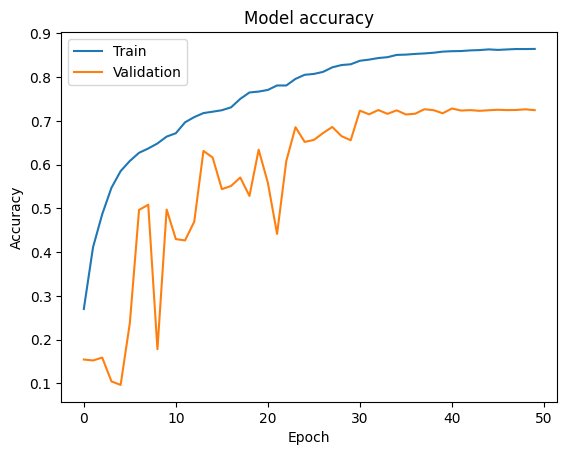

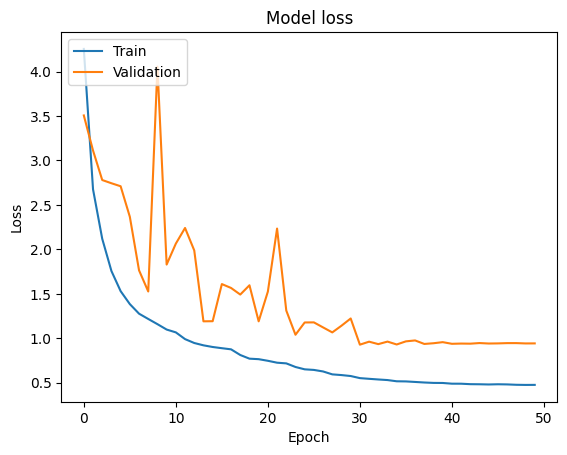

In [7]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

#### 2.5 Make Predictions

In [9]:
# Make predictions
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)

# Prepare the submission file
submission = np.column_stack((id_test, predicted_labels))

# Save the submission file to the desired path
submission_file_path = 'D:\\MSA_Project\\MSA_Phase2\\outputs\\submission.csv'
np.savetxt(submission_file_path, submission, delimiter=',', header='id,label', comments='', fmt='%d')



157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


### 3. Summary

+ The model was trained and validated using CNN with appropriate data splits techniques.
+ Predictions for the test set were generated and saved for submission to Kaggle.
+ Due to limited time, the model was pretty simple and naive which then led to underfitting for the test data. The next plan is to include experimenting with different model architectures, further tuning hyperparameters, and exploring data augmentation techniques, etc.